# VIVEK VIJAY

# Problem No 1
Key Driver Analysis:

Objective: Conduct Key Driver Analysis on customer feedback datasets to identify the most influential factors
impacting satisfaction scores or sentiment ratings, facilitating targeted improvements in customer experience
management.

I have utilized 20% (10,000 reviews) of the total 50,000 reviews available to balance computational efficiency and reduce time complexity . This approach significantly reduces computational load and speeds up the workflow, enabling quicker iterations and refinements.Using a subset serves as an initial analysis phase to validate the methodology, identify potential issues, and make necessary adjustments before scaling up to the full dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sample data

In [73]:
import pandas as pd

# Load the data
file_path = '/content/drive/MyDrive/SurveySparrow/IMDB Dataset.csv'
data = pd.read_csv(file_path)

# Taking Sample 20% of the data
sampled_data = data.sample(frac=0.2, random_state=6)

#Saving the sampled data for further processing
sampled_data.to_csv('/content/drive/MyDrive/SurveySparrow/sampled data.csv', index=False)

print("Sampled data saved.")


Sampled data saved.


# Preprocessing



In [74]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

class DataPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        # Lowercase the text
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', ' ', text)
        # Remove special characters and digits
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\d', ' ', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        return text

    def get_pos_tag(self, word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def tokenize_and_lemmatize(self, text):
        words = word_tokenize(text)
        filtered_text = [self.lemmatizer.lemmatize(word, self.get_pos_tag(word)) for word in words if word not in self.stop_words]
        return ' '.join(filtered_text)

    def preprocess(self, text):
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load and Preprocess Data



In [75]:
import pandas as pd
from tqdm import tqdm

# Load the  sample dataset
file_path = '/content/drive/MyDrive/SurveySparrow/sampled data.csv'
data = pd.read_csv(file_path)

# Initialize the preprocessor
preprocessor = DataPreprocessor()

# Add tqdm  for progress tracking
tqdm.pandas()

# Apply the preprocessing function to the review column
data['cleaned_review'] = data['review'].progress_apply(preprocessor.preprocess)

output_path = '/content/drive/MyDrive/SurveySparrow/preprocessed_data.csv'
data.to_csv(output_path, index=False)

print("Data preprocessing complete. Cleaned and tokenized data saved.")


100%|██████████| 10000/10000 [02:47<00:00, 59.69it/s]


Data preprocessing complete. Cleaned and tokenized data saved.


# Keyword Extraction Class



In [76]:
from sklearn.feature_extraction.text import CountVectorizer

class KeywordExtractor:
    def __init__(self, max_features=100, ngram_range=(1, 2)):
        self.vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)

    def fit_transform(self, documents):
        return self.vectorizer.fit_transform(documents)

    def transform(self, documents):
        return self.vectorizer.transform(documents)

    def get_feature_names(self):
        return self.vectorizer.get_feature_names_out()


# Script to Extract Keywords

In [77]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# Load the preprocessed data
file_path = '/content/drive/MyDrive/SurveySparrow/preprocessed_data.csv'
data = pd.read_csv(file_path)

# Initialize the keyword extractor class
keyword_extractor = KeywordExtractor()

# Fit and transform the cleaned reviews
cleaned_reviews = data['cleaned_review'].tolist()
X = keyword_extractor.fit_transform(tqdm(cleaned_reviews))

# Get the keywords
keywords = keyword_extractor.get_feature_names()

# Get the raw term frequencies for each keyword
word_count = np.asarray(X.sum(axis=0)).flatten()

# Combine keywords and their raw term frequencies into a DataFrame
keyword_freq_df = pd.DataFrame({
    'Keyword': keywords,
    'Frequency': word_count
})

# Sort the DataFrame by frequency in descending order
keyword_freq_df = keyword_freq_df.sort_values(by='Frequency', ascending=False)

# Display the top 10 keywords
top_keywords = keyword_freq_df.head(10)
print("Top 10 keywords by frequency:\n", top_keywords)

# Save the keyword frequencies to a CSV file
output_path = '/content/drive/MyDrive/SurveySparrow/keyword_frequencies.csv'
keyword_freq_df.to_csv(output_path, index=False)

print("Keyword frequencies saved.")


100%|██████████| 10000/10000 [00:02<00:00, 4582.36it/s]


Top 10 keywords by frequency:
    Keyword  Frequency
50   movie      21008
24    film      19084
56     one      11234
46    make       9315
40    like       8987
70     see       8427
28     get       7153
92    well       6547
84    time       6191
32    good       6030
Keyword frequencies saved.


# Sentiment Analysis



In [78]:
from tqdm import tqdm
from transformers import pipeline

# Initialize the sentiment analyzer
sentiment_analyzer = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def analyze_sentiment_for_keywords(keywords, reviews, max_length=128, batch_size=128):
    keyword_sentiments = []

    for keyword in tqdm(keywords, desc="Analyzing Sentiment for Keywords"):
        keyword_reviews = [review for review in reviews if keyword in review]
        if not keyword_reviews:
            continue  # Skip keywords with no associated reviews

        # Ensuring all reviews are strings and truncate to the maximum length
        truncated_reviews = [str(review)[:max_length] for review in keyword_reviews]

        sentiments = []
        # Batch processing
        for i in range(0, len(truncated_reviews), batch_size):
            batch = truncated_reviews[i:i + batch_size]
            sentiments.extend(sentiment_analyzer(batch))

        positive_score = sum(1 for sentiment in sentiments if sentiment['label'] == 'POSITIVE')
        negative_score = sum(1 for sentiment in sentiments if sentiment['label'] == 'NEGATIVE')

        total = positive_score + negative_score
        if total == 0:
            continue  # Skip if there's no sentiment detected

        if positive_score > negative_score :
            sentiment = 'positive'
            score = positive_score / total
        elif negative_score > positive_score :
            sentiment = 'negative'
            score = negative_score / total
        else:
            pass

        keyword_sentiments.append({'Keyword': keyword, 'Sentiment': sentiment, 'Score': score})

    return keyword_sentiments


In [79]:
import pandas as pd
from tqdm import tqdm

# Load the top 100 terms
top_terms_path = '/content/drive/MyDrive/SurveySparrow/keyword_frequencies.csv'
top_terms_df = pd.read_csv(top_terms_path)
top_terms = top_terms_df['Keyword'].tolist()

# Load the preprocessed data
file_path = '/content/drive/MyDrive/SurveySparrow/preprocessed_data.csv'
data = pd.read_csv(file_path)

# Get the list of cleaned reviews from the data
cleaned_reviews = data['cleaned_review'].tolist()

# Analyze sentiment for the extracted keywords
keyword_sentiments = analyze_sentiment_for_keywords(top_terms, cleaned_reviews)

# Convert the sentiments to a DataFrame
keyword_sentiments_df = pd.DataFrame(keyword_sentiments)

# Merge the sentiment results with the top terms DataFrame
result_df = top_terms_df.merge(keyword_sentiments_df, on='Keyword')

# Display the results
print("Keywords with sentiment analysis:\n", result_df)

# Save the results
output_path = '/content/drive/MyDrive/SurveySparrow/keyword_sentiment_analysis_top_500.csv'
result_df.to_csv(output_path, index=False)

print("Sentiment analysis complete. Results saved.")


Analyzing Sentiment for Keywords: 100%|██████████| 100/100 [2:21:54<00:00, 85.14s/it]

Keywords with sentiment analysis:
    Keyword  Frequency Sentiment     Score
0    movie      21008  negative  0.607330
1     film      19084  negative  0.569921
2      one      11234  negative  0.591466
3     make       9315  negative  0.603939
4     like       8987  negative  0.612677
..     ...        ...       ...       ...
95  comedy       1471  negative  0.571711
96  around       1455  negative  0.608550
97    line       1445  negative  0.598650
98  pretty       1436  negative  0.643106
99    kill       1423  negative  0.648876

[100 rows x 4 columns]
Sentiment analysis complete. Results saved.


#Calculate Combined Importance

In [80]:
import pandas as pd

class ImportanceCalculator:
    def __init__(self, frequency_col='Frequency', sentiment_col='Score'):
        self.frequency_col = frequency_col
        self.sentiment_col = sentiment_col

    def calculate_combined_importance(self, df):
        # Calculate the combined importance score
        df['Combined_Importance'] = df[self.frequency_col] * df[self.sentiment_col]
        return df


In [81]:
import pandas as pd

# Load the top 100 keywords with their sentiment and frequency
top_keywords_path = '/content/drive/MyDrive/SurveySparrow/keyword_sentiment_analysis_top_100.csv'
keywords_df = pd.read_csv(top_keywords_path)

# Initialize the importance calculator
importance_calculator = ImportanceCalculator()

# Calculate the combined importance score
keywords_df = importance_calculator.calculate_combined_importance(keywords_df)

# Display the top 10 keywords by combined importance score
top_keywords_by_importance = keywords_df.sort_values(by='Combined_Importance', ascending=False).head(10)
print("Top 10 keywords by combined importance:\n", top_keywords_by_importance)

# Save the combined importance scores
output_path = '/content/drive/MyDrive/SurveySparrow/combined_importance_scores.csv'
keywords_df.to_csv(output_path, index=False)

print("Combined importance scores saved.")


Top 10 keywords by combined importance:
    Keyword  Frequency Sentiment     Score  Combined_Importance
0    movie      21008  negative  0.607330         12758.785340
1     film      19084  negative  0.569921         10876.377826
2      one      11234  negative  0.591466          6644.527662
3     make       9315  negative  0.603939          5625.689278
4     like       8987  negative  0.612677          5506.131693
5      see       8427  negative  0.593562          5001.950133
6      get       7153  negative  0.615773          4404.625097
12     bad       5430  negative  0.749770          4071.251150
7     well       6547  negative  0.563788          3691.119472
8     time       6191  negative  0.588575          3643.869304
Combined importance scores saved.


#Actionable Insights

In [82]:
import pandas as pd

class ActionableInsightsProvider:
    def __init__(self, keyword_col='Keyword', sentiment_col='Sentiment', importance_col='Combined_Importance'):
        self.keyword_col = keyword_col
        self.sentiment_col = sentiment_col
        self.importance_col = importance_col

    def provide_actionable_insights(self, df):
        insights = []
        for _, row in df.iterrows():
            keyword = row[self.keyword_col]
            sentiment = row[self.sentiment_col]
            importance = row[self.importance_col]

            if sentiment == 'positive':
                action = f"Continue to focus on {keyword} as it positively impacts customer satisfaction."
            elif sentiment == 'negative':
                action = f"Investigate and address issues related to {keyword} to improve customer satisfaction."
            else:
              pass

            insights.append({'Keyword': keyword, 'Sentiment': sentiment, 'Importance': importance, 'Action': action})

        return pd.DataFrame(insights)


In [83]:
import pandas as pd

# Load the combined importance scores
combined_scores_path = '/content/drive/MyDrive/SurveySparrow/combined_importance_scores.csv'
combined_df = pd.read_csv(combined_scores_path)

# Initialize the actionable insights provider
insights_provider = ActionableInsightsProvider()

# Provide actionable insights based on the combined importance scores
actionable_insights = insights_provider.provide_actionable_insights(combined_df)

# Display the actionable insights
print("Actionable insights:\n", actionable_insights)

# Save the actionable insights
output_path = '/content/drive/MyDrive/SurveySparrow/actionable_insights.csv'
actionable_insights.to_csv(output_path, index=False)

print("Actionable insights saved.")


Actionable insights:
    Keyword Sentiment    Importance  \
0    movie  negative  12758.785340   
1     film  negative  10876.377826   
2      one  negative   6644.527662   
3     make  negative   5625.689278   
4     like  negative   5506.131693   
..     ...       ...           ...   
95  comedy  negative    840.987141   
96  around  negative    885.440067   
97    line  negative    865.049325   
98  pretty  negative    923.500873   
99    kill  negative    923.351124   

                                               Action  
0   Investigate and address issues related to movi...  
1   Investigate and address issues related to film...  
2   Investigate and address issues related to one ...  
3   Investigate and address issues related to make...  
4   Investigate and address issues related to like...  
..                                                ...  
95  Investigate and address issues related to come...  
96  Investigate and address issues related to arou...  
97  Investigate a

#Visual Representation

In [84]:
import pandas as pd

class DataPreparer:
    def __init__(self, sentiment_col='Sentiment', importance_col='Combined_Importance', keyword_col='Keyword'):
        self.sentiment_col = sentiment_col
        self.importance_col = importance_col
        self.keyword_col = keyword_col

    def prepare_data(self, df):
        # Map sentiment to numerical values for plotting
        sentiment_mapping = {'positive': 1, 'negative': -1}
        df['Sentiment_Polarity'] = df[self.sentiment_col].map(sentiment_mapping)
        return df

# Load the combined importance scores
combined_scores_path = '/content/drive/MyDrive/SurveySparrow/combined_importance_scores.csv'
combined_df = pd.read_csv(combined_scores_path)

# Initialize the data preparer
data_preparer = DataPreparer()

# Prepare the data
prepared_df = data_preparer.prepare_data(combined_df)

# Display the prepared data
print("Prepared data for visualization:\n", prepared_df.head())


Prepared data for visualization:
   Keyword  Frequency Sentiment     Score  Combined_Importance  \
0   movie      21008  negative  0.607330         12758.785340   
1    film      19084  negative  0.569921         10876.377826   
2     one      11234  negative  0.591466          6644.527662   
3    make       9315  negative  0.603939          5625.689278   
4    like       8987  negative  0.612677          5506.131693   

   Sentiment_Polarity  
0                  -1  
1                  -1  
2                  -1  
3                  -1  
4                  -1  


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    def __init__(self, x_col='Sentiment_Polarity', y_col='Combined_Importance', keyword_col='Keyword'):
        self.x_col = x_col
        self.y_col = y_col
        self.keyword_col = keyword_col

    def create_scatter_plot(self, df):
        # Set the style of the visualization
        sns.set(style="whitegrid")

        # Create the scatter plot
        plt.figure(figsize=(12, 8))
        scatter = sns.scatterplot(data=df, x=self.x_col, y=self.y_col, hue='Sentiment', style='Sentiment', s=100)

        # Customize the plot
        plt.title('Keyword Importance vs. Sentiment Polarity', fontsize=16)
        plt.xlabel('Sentiment Polarity (from positive to negative)', fontsize=14)
        plt.ylabel('Importance Score', fontsize=14)
        plt.legend(title='Sentiment')
        plt.grid(True)

        # Annotate the points with keywords
        for line in range(0, df.shape[0]):
            scatter.text(df[self.x_col][line], df[self.y_col][line], df[self.keyword_col][line],
                         horizontalalignment='left', size='medium', color='black', weight='semibold')

        # Show the plot
        plt.show()


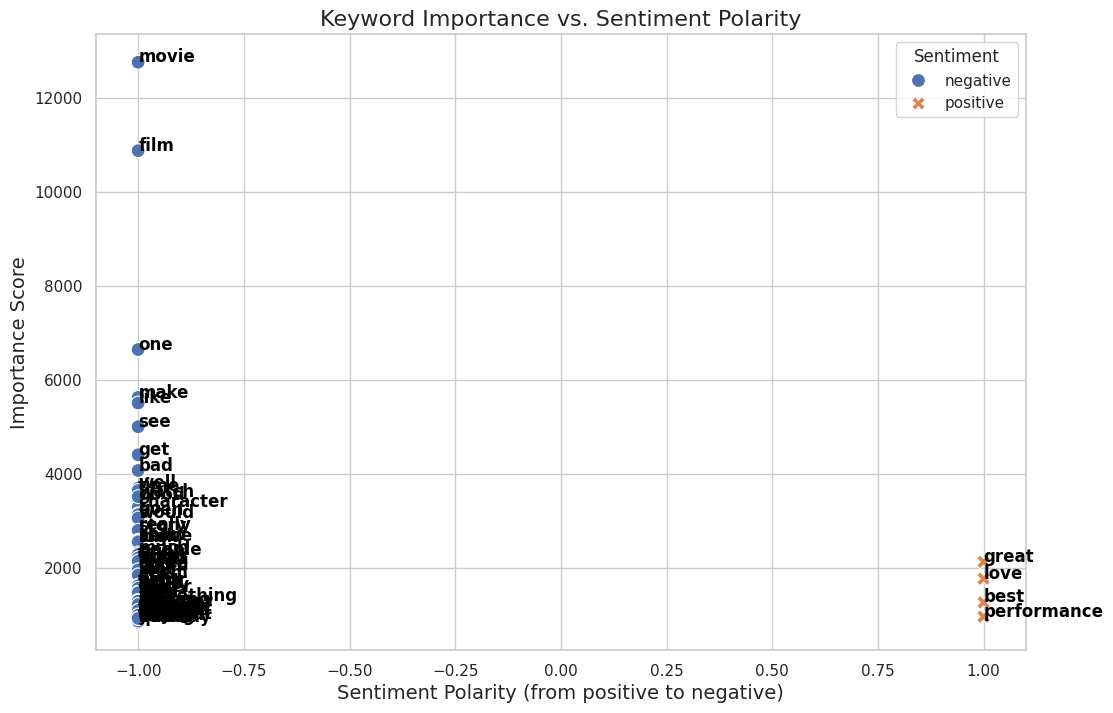

In [100]:
# Initialize the data visualizer
visualizer = DataVisualizer()

# Create and display the scatter plot
visualizer.create_scatter_plot(prepared_df)
